<a href="https://colab.research.google.com/github/jlev13/2028-Election-Prediction-Model/blob/main/2028_Simulation_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Saving Arizona_County_Data.csv to Arizona_County_Data (31).csv
Mean Simulated Margin: -6.550%
80% Confidence Interval: [-9.347%, -3.740%]
90% Confidence Interval: [-10.170%, -2.954%]
95% Confidence Interval: [-10.874%, -2.281%]
Democratic Win Probability: 0.152%


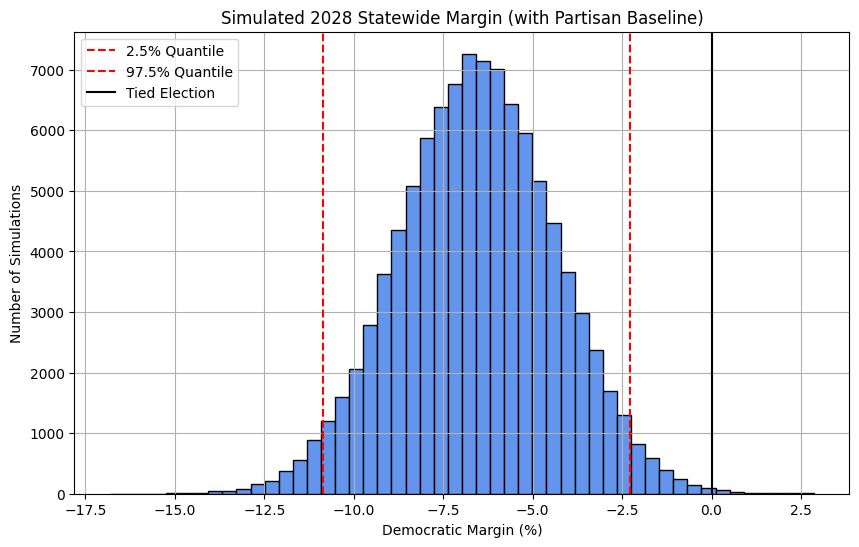

In [ ]:
# Simulate 2028 Presidential Election from County-Level Data

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def parse_margin(margin_str):
    """Converts strings like 'D+5.4' or 'R+12.1' into floats (positive for D, negative for R)"""
    if pd.isna(margin_str): return np.nan
    margin_str = str(margin_str).strip()
    if margin_str.startswith('D+'):
        return float(margin_str[2:])
    elif margin_str.startswith('R+'):
        return -float(margin_str[2:])
    return np.nan

def prepare_data_from_input(df):
    """Converts raw sheet into standardized numeric input"""
    return pd.DataFrame({
        'county': df['County'],
        'margin_2012': df['2012 (R+10.1)'].apply(parse_margin),
        'margin_2016': df['2016 (R+3.5)'].apply(parse_margin),
        'margin_2020': df['2020 (D+0.4)'].apply(parse_margin),
        'margin_2024': df['2024 (R+5.5)'].apply(parse_margin),
        'turnout_2024': df['2024 Pop. Est.']
            .astype(str)
            .str.replace(',', '')
            .astype(float)
    })

def weighted_baseline(margins, years, current_year=2028, alpha=0.7):
    weights = np.array([alpha ** (current_year - y) for y in years])
    margins = np.array(margins)
    valid = ~np.isnan(margins)
    if not valid.any():
        return 0
    return np.sum(margins[valid] * weights[valid]) / np.sum(weights[valid])

def simulate_2028_election(county_df, n_simulations=100000, gamma_baseline=0.45):
    """
    Returns:
    - Tuple: (95% confidence interval, Democratic win probability)
    """
    years = [2012, 2016, 2020, 2024]
    simulated_statewide_margins = np.zeros(n_simulations)

    for _, row in county_df.iterrows():
        margins = [row['margin_2012'], row['margin_2016'], row['margin_2020'], row['margin_2024']]
        turnout = row['turnout_2024']

        if pd.isna(turnout) or turnout <= 0:
            continue

        if any(pd.isna(m) for m in margins):
            margins = [0 if pd.isna(m) else m for m in margins]

        margin_2028 = 2 * margins[3] - margins[2]
        baseline = weighted_baseline(margins, years, current_year=2028, alpha=0.7)
        margin_2028 += gamma_baseline * baseline
        margin_std = np.nanstd(margins)

        if np.isnan(margin_std) or margin_std == 0:
            margin_std = 3

        simulated_margins = np.random.normal(margin_2028, margin_std, n_simulations)
        simulated_statewide_margins += simulated_margins * turnout

    total_turnout = county_df['turnout_2024'].sum()
    if total_turnout == 0:
        raise ValueError("Total turnout is zero, cannot normalize simulated margins.")

    simulated_statewide_margins /= total_turnout

    mean_margin = np.mean(simulated_statewide_margins)
    ci_80 = np.percentile(simulated_statewide_margins, [10, 90])
    ci_90 = np.percentile(simulated_statewide_margins, [5, 95])
    ci_95 = np.percentile(simulated_statewide_margins, [2.5, 97.5])
    win_prob = np.mean(simulated_statewide_margins > 0)

    print(f"Mean Simulated Margin: {mean_margin:.3f}%")
    print(f"80% Confidence Interval: [{ci_80[0]:.3f}%, {ci_80[1]:.3f}%]")
    print(f"90% Confidence Interval: [{ci_90[0]:.3f}%, {ci_90[1]:.3f}%]")
    print(f"95% Confidence Interval: [{ci_95[0]:.3f}%, {ci_95[1]:.3f}%]")
    print(f"Democratic Win Probability: {win_prob:.3%}")

    ci_80 = np.percentile(simulated_statewide_margins, [10, 90])
    ci_90 = np.percentile(simulated_statewide_margins, [5, 95])
    ci_95 = np.percentile(simulated_statewide_margins, [2.5, 97.5])

    mean_margin = np.mean(simulated_statewide_margins)

    win_prob = np.mean(simulated_statewide_margins > 0)

    plt.figure(figsize=(10, 6))
    plt.hist(simulated_statewide_margins, bins=50, color='cornflowerblue', edgecolor='black')
    plt.axvline(ci_95[0], color='red', linestyle='--', label='2.5% Quantile')
    plt.axvline(ci_95[1], color='red', linestyle='--', label='97.5% Quantile')
    plt.axvline(0, color='black', linestyle='-', label='Tied Election')
    plt.title("Simulated 2028 Statewide Margin (with Partisan Baseline)")
    plt.xlabel("Democratic Margin (%)")
    plt.ylabel("Number of Simulations")
    plt.legend()
    plt.grid(True)
    plt.show()

    return ci_95, win_prob

# Example usage from personal preprocessed spreadsheets of county-level historical returns:
# df_input = pd.read_csv("{insert whichever region being scrutinized here}_county_data.csv")
# county_data = prepare_data_from_input(df_input)
# ci, prob = simulate_2028_election(county_data)
# print("95% Confidence Interval:", ci)
# print("Democratic Win Probability:", prob)

# Load your input CSV with columns like:
# 'County', '2012 Pop. Est.', '2024 Pop. Est.', '2012 (R+10.1)', ..., '2024 (R+5.5)'
from google.colab import files
uploaded = files.upload()
df_input = pd.read_csv("Arizona_County_Data.csv")

county_data = prepare_data_from_input(df_input)

ci, prob = simulate_2028_election(county_data)
